In [1]:
import pandas as pd
import numpy as np
from preprocessing_unique import create_testdata
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
import pymc3 as pm

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Simple linear model

In [9]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)
#hard to impute by country mean so compromise is to have an overall mean strategy
lm = linear_model.LinearRegression()

kfold=10

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

nested_score = cross_val_score(lm, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=cv)

#estimated training error
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
            
lm.fit(features_train,windspeed_train)

y_predict=lm.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(lm, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

Model is estimated to have generalisation error of -0.6952641276531115 with standard deviation 0.07893960556822052.
[[ 8.27432919  7.87638281]
 [ 8.35030039  8.36911769]
 [ 8.21433635  9.06447   ]
 [ 8.59480469  7.87391418]
 [ 8.2238779   8.64568471]
 [ 8.63825449  8.61594375]
 [ 8.06298781 10.04593444]
 [ 8.13164616  7.54166   ]
 [ 8.13608427  7.64469   ]
 [ 8.00086135  8.30015   ]
 [ 7.70684228  7.989787  ]
 [ 8.12602434  7.60127   ]
 [ 8.11400171  7.559098  ]
 [ 7.90149056  7.802328  ]
 [ 8.05337187  7.50235   ]
 [ 7.77671234  7.690592  ]
 [ 8.1546075   8.15589833]
 [ 7.9352737   7.93789667]
 [ 8.10325322  7.048575  ]
 [ 7.71839353  7.942024  ]
 [ 7.7975727   8.236786  ]
 [ 8.19256506  8.077188  ]
 [ 7.8898144   8.8139    ]
 [ 8.01862362  8.13276083]
 [ 8.01671844  8.18636111]
 [ 8.06237622  8.302422  ]
 [ 8.22669794  8.21303   ]
 [ 7.9981414   8.22001333]
 [ 7.98851377  8.43021125]
 [ 7.89005304  7.71997833]
 [ 8.05142125 12.88638667]
 [ 8.12362374  7.93216571]
 [ 7.99103731  8.161

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


## Ridge

In [86]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',1)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)


In [99]:
reg = linear_model.RidgeCV(alphas=[2.675,2.68,2.685,2.69])
reg.fit(features_train, windspeed_train)  
reg.alpha_

2.685

In [100]:
#hard to impute by country mean so compromise is to have an overall mean strategy
clf = linear_model.Ridge(alpha=reg.alpha_)

kfold=10

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

nested_score = cross_val_score(clf, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=cv)

#estimated training error
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
            
clf.fit(features_train,windspeed_train)

y_predict=clf.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(clf , random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

Model is estimated to have generalisation error of -0.5649177337456657 with standard deviation 0.17372346332276378.
[[ 8.63326637  7.68602486]
 [ 8.73518919  8.31893304]
 [ 4.21855859  7.9324    ]
 [ 7.86054806  8.75241   ]
 [ 8.72627935  8.113635  ]
 [ 6.87880368  8.76709333]
 [ 8.62909262  8.80041833]
 [ 8.63850069  9.03879636]
 [ 7.83404192  7.77843167]
 [ 9.11996922  9.97070667]
 [ 7.79703045  7.73870125]
 [ 7.78789054  7.65075467]
 [ 8.35100132  8.020272  ]
 [ 7.82433415  7.6529975 ]
 [ 8.07340349  8.68454538]
 [ 7.77294938  7.64302   ]
 [ 7.8397562   7.527548  ]
 [ 7.82432832  7.54319333]
 [ 8.06312129  8.18241286]
 [ 8.41451717  7.76495   ]
 [ 7.63930329  7.99128375]
 [ 7.76334654  7.95384333]
 [ 7.98425944  8.31791   ]
 [ 7.69938202  7.49701564]
 [ 7.7741505   7.75600364]
 [ 7.74098893  7.758975  ]
 [ 8.24236899  7.975845  ]
 [ 7.92831853  6.989808  ]
 [ 7.54355754  7.38801   ]
 [ 8.06581485  8.14101   ]
 [ 7.84741429  7.51676167]
 [ 7.6443836   7.5777475 ]
 [ 7.47373593  7.466

## Lasso

In [203]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('50',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [216]:
reg = linear_model.LassoCV(alphas=[0.00845,0.0085,0.00855],cv=10)
reg.fit(features_train, windspeed_train)  
reg.alpha_

0.0085

In [217]:
#hard to impute by country mean so compromise is to have an overall mean strategy
clf = linear_model.Lasso(alpha=reg.alpha_)

kfold=10

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

nested_score = cross_val_score(clf, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=cv)

#estimated training error
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
            
clf.fit(features_train,windspeed_train)

y_predict=clf.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(clf , random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

Model is estimated to have generalisation error of -0.7250365091862977 with standard deviation 0.20352685025677333.
[[6.14981266 6.78029188]
 [6.30792728 6.36836097]
 [5.97278238 5.78262778]
 [6.59347346 5.99021636]
 [6.76339134 6.009295  ]
 [6.04376324 6.05732111]
 [6.77480207 7.74454045]
 [5.92174221 5.438404  ]
 [5.83703737 5.41741733]
 [6.01172236 5.37174   ]
 [6.04594338 6.03887286]
 [6.05385659 7.91033   ]
 [5.67940807 5.194575  ]
 [5.5269842  5.3069    ]
 [6.00201926 5.83168   ]
 [6.0400261  9.8896275 ]
 [5.75399327 5.3971335 ]
 [6.02037975 9.04125625]
 [5.70438169 5.5170925 ]
 [5.94680334 5.568725  ]
 [5.69318949 5.729431  ]
 [5.85555358 5.6662    ]
 [5.83999641 5.69429417]
 [5.95143669 5.95695667]
 [5.92512154 5.20538   ]
 [5.83070353 5.769616  ]
 [5.75160636 5.71133   ]
 [5.98017929 8.041755  ]
 [6.03645993 5.62926182]
 [5.99739186 6.628596  ]
 [5.87981939 5.29645   ]
 [5.82771825 5.84537077]
 [5.47339426 5.600875  ]
 [5.76065302 5.77694333]
 [6.03461533 5.21436   ]
 [5.55737

In [218]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(features_train)
print(features_train.shape)
print(X_new.shape)

(1265, 23)
(1265, 13)


In [219]:
clf.coef_

array([ 0.        , -0.07284212, -0.10477633, -0.23415096,  0.04739415,
        0.        , -0.04929005,  0.01857456,  0.00605324,  0.12277669,
        0.        ,  0.18277693, -0.19814957,  0.        , -0.50868085,
       -0.        ,  0.1039269 ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.44565688])

In [220]:
mask=model.get_support()
x = np.ma.array(features_train.columns, mask=mask)
x.compressed()

array(['Distance to the closest Airport (kms)',
       'Distance to the closest Vegetation (kms)', 'Long', 'India',
       'Japan', 'Portugal', 'Scotland', 'South Africa', 'Spain',
       'Thailand'], dtype=object)

## Elastic Net


In [273]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [274]:
#hard to impute by country mean so compromise is to have an overall mean strategy
regr = linear_model.ElasticNetCV(cv=10)

kfold=10

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

nested_score = cross_val_score(regr, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=cv)

#estimated training error
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
            
regr.fit(features_train,windspeed_train)

y_predict=regr.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(regr , random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

Model is estimated to have generalisation error of -0.6914714110153494 with standard deviation 0.11438671723510413.
[[ 8.36377636  8.75241   ]
 [ 8.12574695  8.64568471]
 [ 8.35216808  7.42875481]
 [ 8.37693971  8.66845667]
 [ 8.14412392  8.15118765]
 [ 8.52988585  8.41337833]
 [ 8.73464473  8.44009   ]
 [ 8.11061298  8.34771   ]
 [ 8.06688455  7.706814  ]
 [ 8.0794058   8.416162  ]
 [ 8.02681116  8.31791   ]
 [ 8.0665909   8.0213    ]
 [ 8.14586134  9.53195167]
 [ 8.17531768  8.04165818]
 [ 8.00904612  7.73607125]
 [ 7.76662303  8.050235  ]
 [ 8.08643806  7.90795   ]
 [ 8.06302621  7.6974275 ]
 [ 8.00739876  8.08916923]
 [ 7.90553513  8.41924333]
 [ 8.03887608  7.76170833]
 [ 7.65735628  7.97411625]
 [ 7.71778912  7.989787  ]
 [ 8.10982159  8.096685  ]
 [ 7.99477416  8.292701  ]
 [ 7.99529277  8.41802125]
 [ 7.9925454   7.36909909]
 [ 7.8841953   8.05312833]
 [ 8.07749888  7.5366388 ]
 [ 8.07214377  9.54866   ]
 [ 8.14103788  8.0045524 ]
 [ 7.97646209  8.09831   ]
 [ 8.00143819  7.382

In [275]:
regr.coef_

array([ 0.00461427, -0.08005385, -0.15559418, -0.10675896,  0.03638588,
        0.00518404, -0.05799168, -0.00122211, -0.02677837,  0.12013923,
       -0.        ,  0.26458541,  0.04760308, -0.02636663, -0.62476943,
       -0.05703878,  0.10553844, -0.32010241,  0.84265473, -0.        ,
       -0.18704135, -0.        ,  0.07740129])

In [276]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(regr, prefit=True)
X_new = model.transform(features_train)
print(features_train.shape)
print(X_new.shape)

(1268, 23)
(1268, 6)


In [277]:
mask=model.get_support()
x = np.ma.array(features_train.columns, mask=mask)
x.compressed()

array(['Distance to the closest Airport (kms)',
       'Distance to the closest Builtup (kms)',
       'Distance to the closest Agricultural area (kms)',
       'Distance to the closest Settlement (kms)',
       'Distance to the closest Vegetation (kms)',
       'Distance to the closest Water (kms)',
       'Distance to the closest Forest (kms)',
       'Distance to the closest Grassland (kms)', 'Lat', 'Long', 'France',
       'India', 'Japan', 'Philippines', 'South Africa', 'Thailand',
       'Turkey'], dtype=object)

In [ ]:
# X_new_test = model.transform(features_test)
regr.fit(X_new,windspeed_train)
y_predict=regr.predict(X_new_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

## PLS regression

In [311]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [312]:
kfold=10 #default 10-fold cross validation
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression()
# specify parameters to compute grid search on the the parameter scoring function

# specify parameters and distributions to sample from
param_dist = {"n_components": [2,3,4,5,6,7,8,9]}

inner_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

clf = GridSearchCV(estimator=pls, param_grid=param_dist,scoring='neg_mean_squared_error', cv=inner_cv)
nested_score = cross_val_score(pls, features_train.values, windspeed_train, scoring='neg_mean_squared_error',cv=outer_cv)
clf.fit(features_train.values,windspeed_train)
print("Best model has mse of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
print(clf.best_params_)

Best model has mse of -0.6987860819931886 with standard deviation 0.149517073927129.
{'n_components': 5}


In [313]:
y_predict=clf.predict(features_test)
print(np.vstack((y_predict, windspeed_test.reshape(windspeed_test.shape[0],1))).T)
final_error=-np.sum(np.square(y_predict-windspeed_test.reshape(windspeed_test.shape[0],1)))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(clf , random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

[[ 8.46986983  8.34623896  8.33039043  8.5639775   8.46546004  8.1711893
   8.34978817  8.09027907  7.92985725  8.10634158  8.05758355  8.12694515
   7.97611245  8.06480473  8.01763458  8.01440866  7.90967626  8.03501482
   8.06842129  8.13859804  8.05532903  7.86409086  8.03355325  7.89428994
   7.88342554  8.02223933  8.05924641  8.06447688  8.16551775  7.97223253
   7.8106416   7.97019362  8.15701911  8.06389055  8.16039444  7.77261093
   8.17587906  7.99385621  8.11707839  8.14654871  8.09725129  8.03186092
   8.07572167  8.16839115  7.60416874  8.18033661  8.20398256  8.00298621
   8.04147557  8.10004022  8.0521158   8.08704018  8.1289047   7.31512997
   7.30607741  5.43158584  5.45703347  5.347663    5.25201594  5.3065627
   5.40842904  5.50110786  5.47884801  5.44758312  5.39598666  7.52524958
   7.67081147  7.64564812  7.63410396  7.56007144  7.50289408  7.58464148
   7.60752505  7.41802919  7.5099291   7.50810974  9.17790026  9.15075405
   9.08099985  9.18687653  7.0493683   7

## Bayesian Ridge

In [364]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [365]:
kfold=10 #default 10-fold cross validation
reg = linear_model.BayesianRidge(compute_score=True)

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)
nested_score = cross_val_score(reg, features_train.values, windspeed_train, scoring='neg_mean_squared_error',cv=cv)
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))


Model is estimated to have generalisation error of -0.696186335304914 with standard deviation 0.10856150298973757.


In [366]:
reg.fit(features_train.values,windspeed_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [367]:
reg.alpha_

1.4588413124562176

In [368]:
reg.lambda_

12.800564582894129

In [369]:
y_predict=reg.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(reg , random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

[[8.43100268 8.09665217]
 [8.49583262 8.44222721]
 [8.46362137 8.41337833]
 [8.3160548  8.7322108 ]
 [8.4179743  8.36911769]
 [8.46968179 8.45757826]
 [8.48431105 9.21835294]
 [8.07209874 7.34855   ]
 [8.03949605 7.44989545]
 [7.98661408 8.397416  ]
 [8.10780641 7.50235   ]
 [8.06791941 8.26947917]
 [8.17846548 7.62898   ]
 [8.09638516 6.989808  ]
 [8.11658653 9.71346125]
 [7.85658252 7.865947  ]
 [7.98967729 8.18386   ]
 [8.12740143 7.62712   ]
 [8.18849334 7.50476667]
 [8.13431875 7.61315   ]
 [8.20351884 8.7360725 ]
 [7.97678085 7.67681   ]
 [8.03534073 7.65854   ]
 [8.05418077 7.70952667]
 [7.89149053 7.76842889]
 [8.09884774 6.926858  ]
 [8.14765217 7.90093667]
 [8.13312004 7.73326   ]
 [8.16131582 8.0045524 ]
 [7.68524923 8.02972158]
 [7.99034211 8.16139   ]
 [7.96841692 7.79374286]
 [8.13794874 8.096685  ]
 [8.1218697  9.62946   ]
 [8.19178517 8.04165818]
 [8.16536542 7.711276  ]
 [7.96305757 7.860048  ]
 [7.69629682 7.989787  ]
 [8.12994678 7.90795   ]
 [8.15377797 8.06840818]


Text(0.5, 0, 'Iterations')

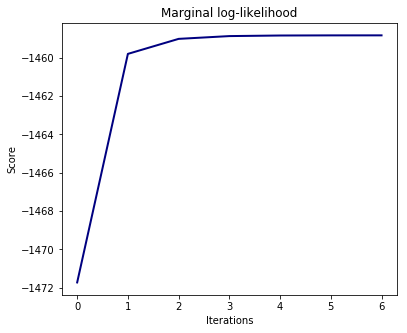

In [370]:
import matplotlib.pyplot as plt
lw=2
plt.figure(figsize=(6, 5))
plt.title("Marginal log-likelihood")
plt.plot(reg.scores_, color='navy', linewidth=lw)
plt.ylabel("Score")
plt.xlabel("Iterations")

## Automatic Relevance Determination - ARD

In [509]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',1)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

In [510]:
kfold=10 #default 10-fold cross validation
reg = linear_model.ARDRegression(compute_score=True)

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)
nested_score = cross_val_score(reg, features_train.values, windspeed_train, scoring='neg_mean_squared_error',cv=cv)
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))


Model is estimated to have generalisation error of -0.5498382761434268 with standard deviation 0.1057887413445833.


In [511]:
reg.fit(features_train.values,windspeed_train)

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=10000.0, tol=0.001, verbose=False)

In [512]:
reg.alpha_

2.0208467696229855

In [513]:
reg.lambda_

array([7.60868577e+00, 1.19842353e+04, 8.81262149e+01, 6.92118833e+02,
       8.04070695e+02, 4.90038648e+04, 3.70177297e+00, 4.39718333e+04,
       5.55872691e+03, 6.96732801e+03, 2.46149684e+04, 1.49013098e+04,
       9.26489337e+01, 1.02521607e+04, 7.99668630e+01, 8.09353954e+01,
       4.39142641e+05, 2.31690304e+05, 8.03463800e-01, 1.97334711e-01,
       1.45489757e+03, 2.86389088e-01, 2.82138706e+04, 2.40088400e-01,
       2.00347993e+03, 8.93994246e+02, 2.06987907e+03, 3.91101048e+00])

In [514]:
y_predict,y_std=reg.predict(features_test.values,return_std=True)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
final_std=np.sum(y_std)/len(windspeed_test)
print('mse error on test set is {} with standard deviation of {}.'.format(final_error,final_std))

perm = PermutationImportance(reg , random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

[[ 8.61492838  8.31794083]
 [ 8.93206555  8.639304  ]
 [ 8.61314528  8.89122034]
 [ 8.44529287  8.27285381]
 [ 8.53825585  7.68602486]
 [ 8.48360101  8.78341   ]
 [ 8.51556513  8.06607702]
 [ 8.18826565  8.050235  ]
 [ 9.05081153 10.03745875]
 [ 8.86703028  8.46869462]
 [ 7.75959978  7.50476667]
 [ 7.7287241   7.64628154]
 [ 7.95390758  7.903645  ]
 [ 7.9297487   8.09541   ]
 [ 7.94240499  8.2165875 ]
 [ 8.06544269  7.559098  ]
 [ 7.90322914  7.75022286]
 [ 8.54228981  7.867402  ]
 [ 7.69741926  7.98274385]
 [ 7.43959971  7.38801   ]
 [ 7.65089659  7.4529535 ]
 [ 7.71644737  7.86676167]
 [ 7.81384177  8.16139   ]
 [ 9.0868147   9.33091125]
 [ 8.00476719  6.67486667]
 [ 7.94594323  8.4659725 ]
 [ 7.96050058  8.439784  ]
 [ 8.31639978  7.71997833]
 [ 7.70511471  7.05374714]
 [ 7.86762202  8.13276083]
 [ 7.81115731  8.18928   ]
 [ 7.85999439  8.06840818]
 [ 7.92028896  8.31791   ]
 [ 7.9858377   8.302422  ]
 [ 7.81001758  8.1817425 ]
 [ 8.30877738  7.90273   ]
 [ 8.33036876  7.66538375]
 

Text(0.5, 0, 'Iterations')

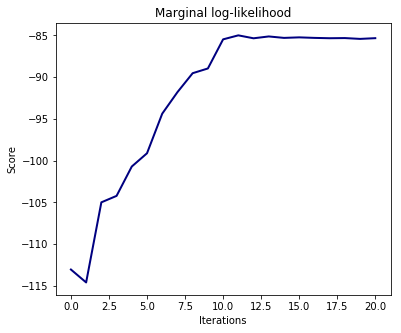

In [515]:
import matplotlib.pyplot as plt
lw=2
plt.figure(figsize=(6, 5))
plt.title("Marginal log-likelihood")
plt.plot(reg.scores_, color='navy', linewidth=lw)
plt.ylabel("Score")
plt.xlabel("Iterations")

In [516]:
reg.coef_

array([-3.59921227e-01,  0.00000000e+00, -1.02880868e-01, -3.04310424e-02,
       -2.55517437e-02,  0.00000000e+00, -5.16403174e-01,  0.00000000e+00,
       -5.39010795e-03,  3.10127858e-03,  0.00000000e+00,  0.00000000e+00,
       -9.97398378e-02,  0.00000000e+00,  1.06634743e-01,  1.05013829e-01,
        0.00000000e+00,  0.00000000e+00,  1.10844249e+00,  2.24565620e+00,
       -8.41489323e-04, -1.86546679e+00,  0.00000000e+00,  2.03632624e+00,
       -2.52927930e-03,  4.36496528e-04, -6.41684004e-05,  4.92454420e-01])

In [517]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(reg, prefit=True)
X_new = model.transform(features_train)
print(features_train.shape)
print(X_new.shape)

(728, 28)
(728, 7)


In [518]:
mask=model.get_support()
x = np.ma.array(features_train.columns, mask=mask)
x.compressed()

array(['Distance to the closest Builtup (kms)',
       'Distance to the closest roads (kms)',
       'Distance to the closest Agricultural area (kms)',
       'Distance to the closest Barren area (kms)',
       'Distance to the closest Settlement (kms)',
       'Distance to the closest Vegetation (kms)',
       'Distance to the closest Water (kms)',
       'Distance to the closest Wetland (kms)',
       'Distance to the closest Forest (kms)',
       'Distance to the closest Grassland (kms)',
       'Distance to the closest Substation (kms)', 'meters',
       'Elevation of Turbines (meters)', 'Slope', 'Lat', 'Long', 'India',
       'Portugal', 'South Africa', 'Spain', 'Thailand'], dtype=object)

In [519]:
X_new_test = model.transform(features_test)
reg.fit(X_new,windspeed_train)
y_predict,y_std=reg.predict(X_new_test,return_std=True)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
final_std=np.sum(y_std)/len(windspeed_test)
print('mse error on test set is {} with standard deviation of {}.'.format(final_error,final_std))

[[ 8.37935406  8.31794083]
 [ 8.36497185  8.639304  ]
 [ 8.4042075   8.89122034]
 [ 8.38013628  8.27285381]
 [ 8.39409637  7.68602486]
 [ 8.37006562  8.78341   ]
 [ 8.36049811  8.06607702]
 [ 8.37313529  8.050235  ]
 [ 9.18662523 10.03745875]
 [ 9.13321381  8.46869462]
 [ 7.76379795  7.50476667]
 [ 7.74366861  7.64628154]
 [ 7.90593332  7.903645  ]
 [ 7.88079241  8.09541   ]
 [ 7.93543227  8.2165875 ]
 [ 7.91407127  7.559098  ]
 [ 7.95558536  7.75022286]
 [ 8.5148797   7.867402  ]
 [ 7.68631208  7.98274385]
 [ 7.45029846  7.38801   ]
 [ 7.71185662  7.4529535 ]
 [ 7.66386443  7.86676167]
 [ 7.83616715  8.16139   ]
 [ 9.06447448  9.33091125]
 [ 8.10746994  6.67486667]
 [ 7.87380898  8.4659725 ]
 [ 7.88876636  8.439784  ]
 [ 8.42616335  7.71997833]
 [ 7.8209315   7.05374714]
 [ 7.81410949  8.13276083]
 [ 7.83545048  8.18928   ]
 [ 7.85543813  8.06840818]
 [ 7.80999452  8.31791   ]
 [ 7.82006794  8.302422  ]
 [ 7.84253443  8.1817425 ]
 [ 8.39238834  7.90273   ]
 [ 8.44053903  7.66538375]
 

## Bayesian linear regression with PYMC3


In [2]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('50',1)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

In [11]:
#let's try standardise the the windspeeds before feeding it into the algo
windspeed_train=windspeed_train.reshape(-1, 1)
windspeed_test=windspeed_test.reshape(-1, 1)
scaler.fit(windspeed_train)
windspeed_train=scaler.transform(windspeed_train)
windspeed_test=scaler.transform(windspeed_test)

In [12]:
features_train['y']=windspeed_train
i_variables=[]
number=len(features_train.columns)
for i in range(number-1):
    i_variables.append('X{}'.format(i))
i_variables.append('y')
keys = features_train.columns.values
values = i_variables
dictionary = dict(zip(keys, values))
features_train.rename(columns=dictionary,inplace=True)
features_test.rename(columns=dictionary,inplace=True)
columns=features_train.columns.values
formula='y ~ '+columns[0]
number=len(columns)
for i in range(1, number-1):
    formula=formula+' + '+columns[i]

In [13]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = features_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, X27, X26, X25, X24, X23, X22, X21, X20, X19, X18, X17, X16, X15, X14, X13, X12, X11, X10, X9, X8, X7, X6, X5, X4, X3, X2, X1, X0, Intercept]
100%|██████████| 2500/2500 [13:16<00:00,  3.07it/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.1304379897974141, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5240875137250623, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The es

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3ce75518>,
      dtype=object)

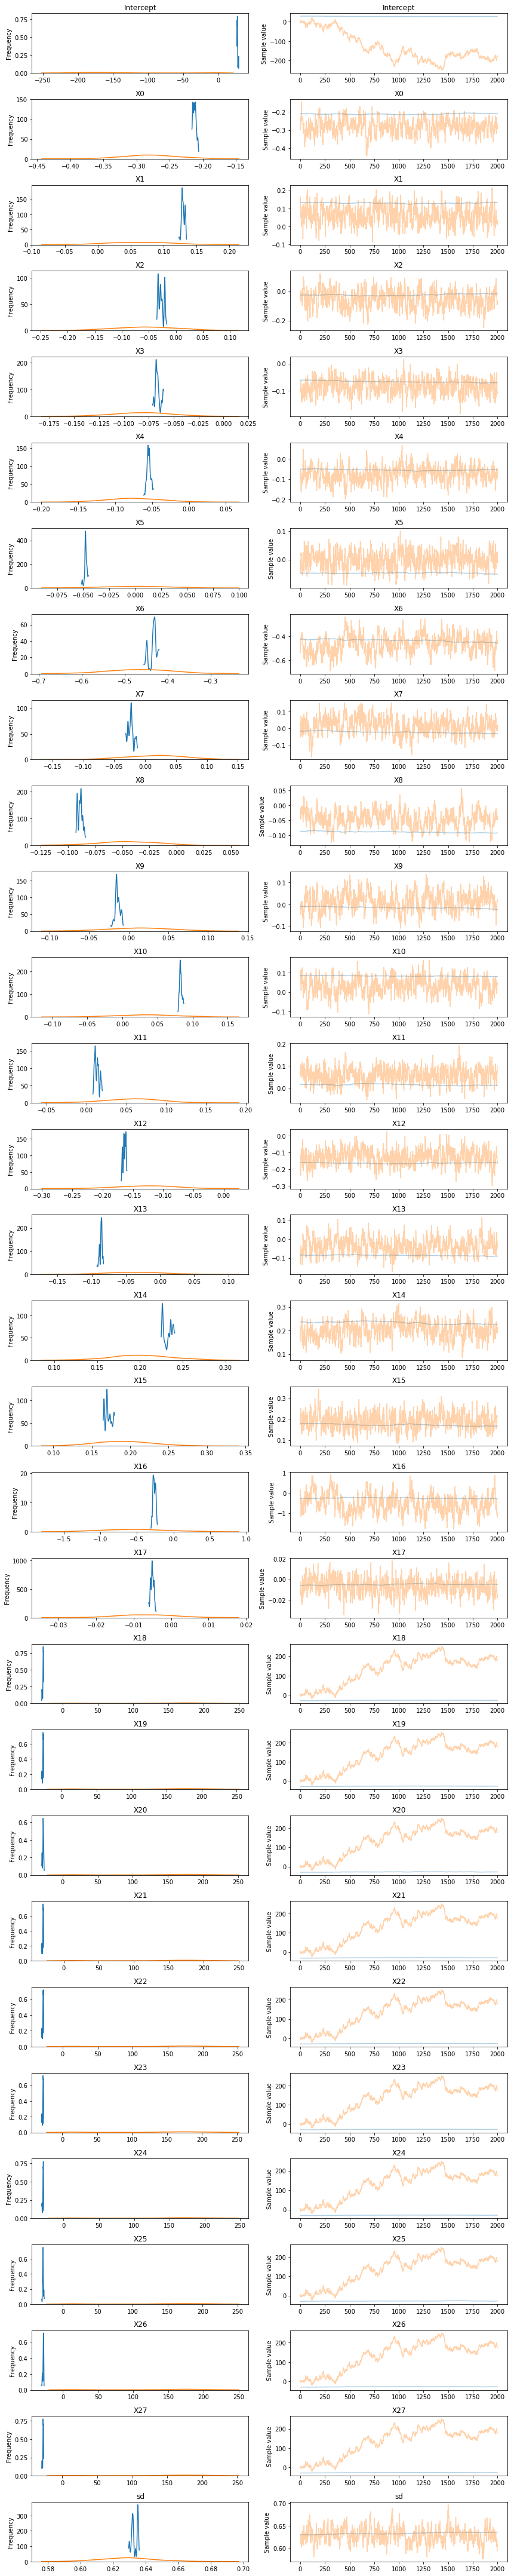

In [14]:
pm.traceplot(normal_trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3cee7f98>,
      dtype=object)

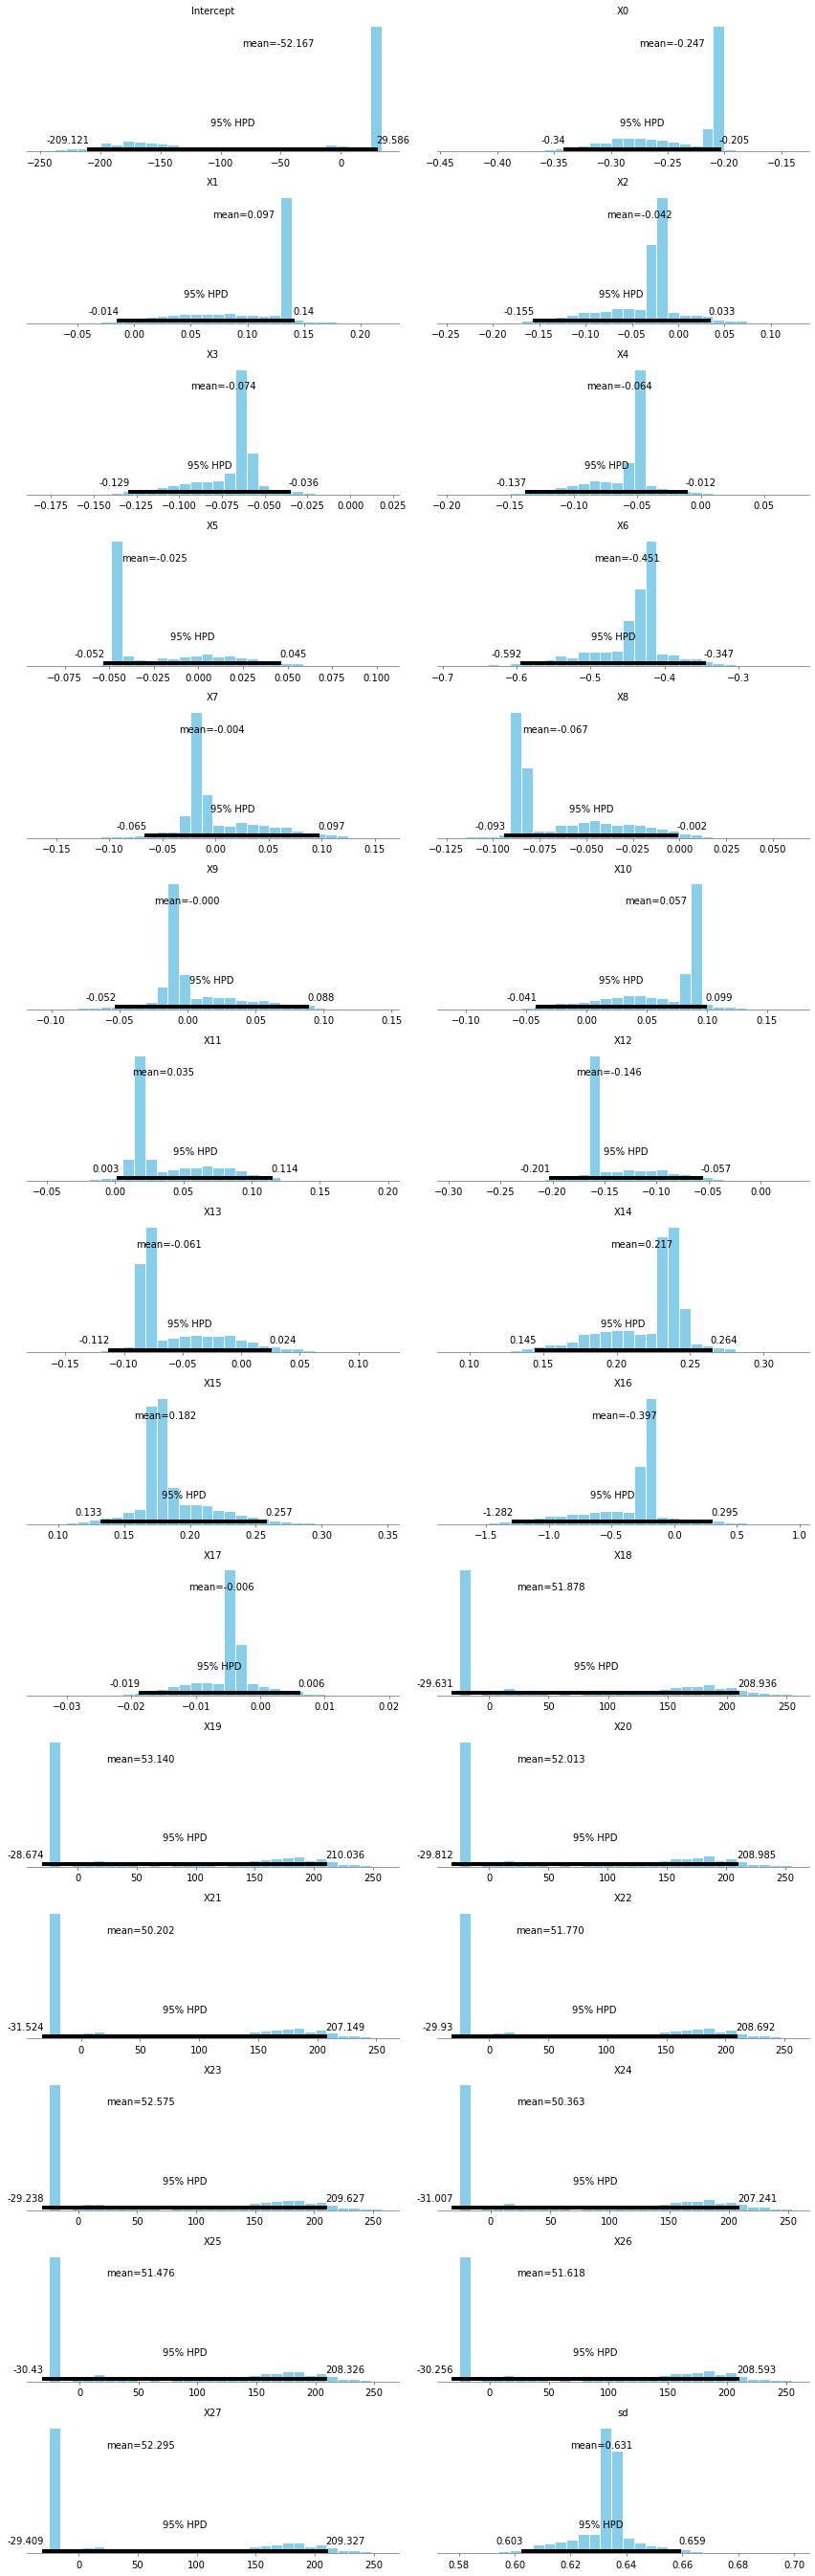

In [15]:
pm.plot_posterior(normal_trace)

In [16]:
model_formula = 'y = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'y =  -52.17 * Intercept + -0.25 * X0 + 0.10 * X1 + -0.04 * X2 + -0.07 * X3 + -0.06 * X4 + -0.02 * X5 + -0.45 * X6 + -0.00 * X7 + -0.07 * X8 + -0.00 * X9 + 0.06 * X10 + 0.04 * X11 + -0.15 * X12 + -0.06 * X13 + 0.22 * X14 + 0.18 * X15 + -0.40 * X16 + -0.01 * X17 + 51.88 * X18 + 53.14 * X19 + 52.01 * X20 + 50.20 * X21 + 51.77 * X22 + 52.57 * X23 + 50.36 * X24 + 51.48 * X25 + 51.62 * X26 + 52.29 * X27 + -0.46 * sd_log__ + 0.63 * sd'

In [17]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_test):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    # Metrics 
    y_pred=scaler.inverse_transform(results['estimate'])
    actual = np.array(scaler.inverse_transform(windspeed_test))
    errors =y_pred - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    return results

In [18]:
results = evaluate_trace(normal_trace, features_train, features_test, windspeed_test)

Model  MAE: 1.0472
Model RMSE: 1.3573


In [20]:
#try out robust regression - replace Gaussian distribution with student t distribution
# Context for the model
with pm.Model() as robust_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.StudentT()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = features_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    robust_trace = pm.sample(draws=2000, chains = 2, tune = 500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, X27, X26, X25, X24, X23, X22, X21, X20, X19, X18, X17, X16, X15, X14, X13, X12, X11, X10, X9, X8, X7, X6, X5, X4, X3, X2, X1, X0, Intercept]
100%|██████████| 2500/2500 [35:55<00:00,  1.16it/s]   
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 671 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3808983810979304, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3f97d898>,
      dtype=object)

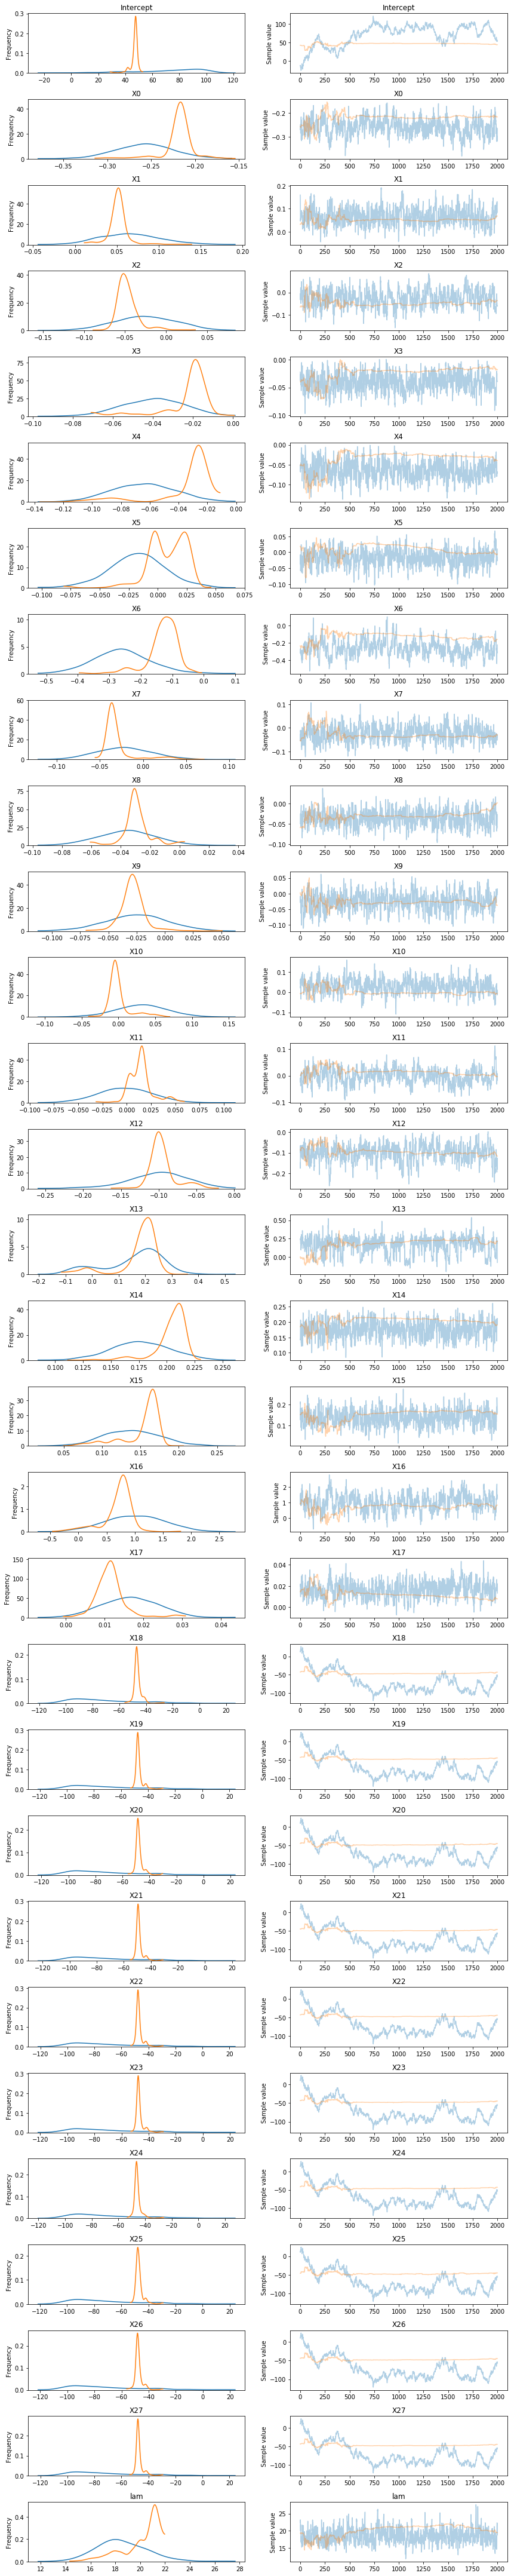

In [22]:
pm.traceplot(robust_trace)

In [25]:
model_formula = 'y = '
for variable in robust_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(robust_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'y =  58.30 * Intercept + -0.24 * X0 + 0.06 * X1 + -0.04 * X2 + -0.03 * X3 + -0.05 * X4 + -0.00 * X5 + -0.20 * X6 + -0.03 * X7 + -0.03 * X8 + -0.03 * X9 + 0.02 * X10 + 0.01 * X11 + -0.10 * X12 + 0.16 * X13 + 0.19 * X14 + 0.15 * X15 + 0.84 * X16 + 0.01 * X17 + -58.02 * X18 + -58.38 * X19 + -59.55 * X20 + -60.32 * X21 + -58.55 * X22 + -58.56 * X23 + -57.10 * X24 + -58.54 * X25 + -59.43 * X26 + -58.74 * X27 + 2.96 * lam_log__ + 19.32 * lam'

In [27]:
results = evaluate_trace(robust_trace, features_train, features_test, windspeed_test)

Model  MAE: 0.9389
Model RMSE: 1.2343


In [ ]:
#Hierachial Linear Regression


## Linear regression with Gaussian basis function

In [599]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [600]:
from sklearn.base import BaseEstimator, TransformerMixin
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for multi-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        # create centres along each columns and combine them together
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

In [604]:
kfold=10 #default 10-fold cross validation
param_dist = {"gaussianfeatures__N": [25,26,27,28]}
#the linear model
lm = linear_model.LinearRegression()
gauss = GaussianFeatures(10)
pipeline=make_pipeline(gauss,lm)

inner_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

clf = GridSearchCV(estimator=pipeline, param_grid=param_dist,scoring='neg_mean_squared_error', cv=inner_cv)
nested_score = cross_val_score(pipeline, features_train.values, windspeed_train, scoring='neg_mean_squared_error',cv=outer_cv)
clf.fit(features_train.values,windspeed_train)
print("Best model has mse of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
print(clf.best_params_)

Best model has mse of -1.188730715899158 with standard deviation 0.17906518762901427.
{'gaussianfeatures__N': 27}


In [602]:
windspeed_predict=clf.predict(features_test.values)
final_error=-np.sum(np.square(windspeed_predict-windspeed_test))/len(windspeed_test)
#print(np.vstack((y_predict, windspeed_test)).T)
print('mse error on test set is {}.'.format(final_error))

#feature importance 
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clf, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

mse error on test set is -1.628024372292365.
                                   feature    weight       std
0                                    Italy  0.192146  0.026374
1                                    Spain  0.017957  0.007536
2    Distance to the closest Builtup (kms)  0.012036  0.010484
3  Distance to the closest Grassland (kms)  0.010879  0.011062
4      Distance to the closest roads (kms)  0.010304  0.005559
5                                 Portugal  0.004863  0.004422
6                                   Turkey  0.002022  0.008331
7                                    India  0.001413  0.004740
8                             South Africa  0.000456  0.002449
9                              Philippines  0.000000  0.000000


## principal component regression

In [69]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [70]:
kfold=10 #default 10-fold cross validation

pca=PCA()
reg = linear_model.LinearRegression()
pipeline=make_pipeline(pca,reg)
# specify parameters to compute grid search on the the parameter scoring function
param_dist = {"pca__n_components": [18,19,20,21,22,23]}

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset.
# E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
inner_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

clf = GridSearchCV(estimator=pipeline, param_grid=param_dist,scoring='neg_mean_squared_error', cv=inner_cv)
# Nested CV with parameter optimization
nested_score = cross_val_score(clf, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=outer_cv)

clf.fit(features_train,windspeed_train)

print("Best model has mse of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
print(clf.best_params_)



/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best model has mse of -0.7068945687952057 with standard deviation 0.07898224411439335.
{'pca__n_components': 20}


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [71]:
windspeed_predict=clf.predict(features_test.values)
final_error=-np.sum(np.square(windspeed_predict-windspeed_test))/len(windspeed_test)
#print(np.vstack((y_predict, windspeed_test)).T)
print('mse error on test set is {}.'.format(final_error))

#feature importance 
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clf, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

mse error on test set is -0.5975582064868038.
                                           feature    weight       std
0                                            Italy  0.909739  0.071078
1                                        Australia  0.375238  0.055659
2                                             Long  0.078201  0.024600
3              Distance to the closest roads (kms)  0.070557  0.016152
4                                         Scotland  0.044578  0.012818
5                                              Lat  0.038409  0.016234
6                                            Spain  0.019367  0.021246
7  Distance to the closest Agricultural area (kms)  0.018743  0.012224
8            Distance to the closest Builtup (kms)  0.018205  0.008161
9              Distance to the closest Water (kms)  0.007183  0.005832


In [72]:
pca=PCA(23)
pca.fit(features_train, windspeed_train)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

[ 20.61  32.03  40.43  48.55  55.92  62.54  68.83  74.7   79.46  83.84
  87.22  90.31  93.21  95.76  97.84  98.85  99.39  99.76  99.96  99.99
 100.   100.   100.  ]


In [73]:
pca=PCA(17)
pca.fit(features_train, windspeed_train)
X_new=pca.transform(features_train)
reg = linear_model.LinearRegression()
nested_score = cross_val_score(reg, X_new, windspeed_train, scoring='neg_mean_squared_error',cv=outer_cv)
print(features_train.shape)
print("Best model has mse of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(1265, 23)
Best model has mse of -0.7341643454155676 with standard deviation 0.0810296313554728.
[20.61 32.03 40.43 48.55 55.92 62.54 68.83 74.7  79.46 83.84 87.22 90.31
 93.21 95.76 97.84 98.85 99.39]


In [74]:
reg.fit(X_new, windspeed_train)
X_test=pca.transform(features_test)
windspeed_predict=reg.predict(X_test)
final_error=-np.sum(np.square(windspeed_predict-windspeed_test))/len(windspeed_test)
#print(np.vstack((y_predict, windspeed_test)).T)
print('mse error on test set is {}.'.format(final_error))

mse error on test set is -0.6499179530055395.


In [75]:
pca.components_

array([[-3.11446203e-01,  3.63519680e-01,  4.97775652e-02,
         9.30083912e-03,  1.87347493e-01,  9.29328790e-02,
        -1.47774083e-02,  1.06760674e-01,  1.59678275e-01,
        -4.52292894e-01,  4.57649629e-01,  4.10672649e-01,
        -2.45685455e-01,  9.48284835e-02, -2.01155015e-02,
         1.51615697e-01,  1.00586408e-01, -2.04623689e-03,
        -5.30344314e-03,  1.25660756e-02, -4.06525691e-02,
         5.52420718e-03,  6.37375673e-03],
       [ 9.60081164e-02,  1.96771407e-01, -1.47234166e-01,
         2.46091250e-01,  2.50197667e-01, -3.53371109e-01,
         4.00842308e-01,  1.78851746e-01, -2.95026552e-01,
        -1.74411990e-01, -2.35980936e-01,  2.00322610e-01,
        -8.10675222e-02,  4.72944794e-02,  2.25859424e-02,
        -4.73274654e-01, -1.75578443e-01, -5.45858311e-03,
        -9.44926101e-04,  1.32488500e-02,  1.08181950e-01,
        -1.61523641e-02, -1.04785316e-02],
       [ 1.78951257e-01,  1.00357274e-02,  1.27093708e-01,
         4.88268931e-01, -1.5

## Factor analysis

In [10]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [13]:
kfold=10 #default 10-fold cross validation

fa=FactorAnalysis()
reg = linear_model.LinearRegression()
pipeline=make_pipeline(fa,reg)
# specify parameters to compute grid search on the the parameter scoring function
param_dist = {"factoranalysis__n_components": [17,18,19]}

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset.
# E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
inner_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

clf = GridSearchCV(estimator=pipeline, param_grid=param_dist,scoring='neg_mean_squared_error', cv=inner_cv)
# Nested CV with parameter optimization
nested_score = cross_val_score(clf, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=outer_cv)

clf.fit(features_train,windspeed_train)

print("Best model has mse of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
print(clf.best_params_)



/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best model has mse of -0.6867949571178429 with standard deviation 0.1463077937445899.
{'factoranalysis__n_components': 18}


In [14]:
windspeed_predict=clf.predict(features_test.values)
final_error=-np.sum(np.square(windspeed_predict-windspeed_test))/len(windspeed_test)
#print(np.vstack((y_predict, windspeed_test)).T)
print('mse error on test set is {}.'.format(final_error))

#feature importance 
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clf, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

mse error on test set is -0.7163787266499861.
                                           feature    weight       std
0                                            Italy  0.817215  0.133621
1                                        Australia  0.281306  0.030685
2                                             Long  0.195003  0.050057
3                                            Spain  0.101975  0.025405
4                                         Portugal  0.060228  0.019306
5  Distance to the closest Agricultural area (kms)  0.051316  0.017021
6                                         Scotland  0.028080  0.024274
7                                            Japan  0.027226  0.010426
8                                     South Africa  0.016122  0.002288
9         Distance to the closest Vegetation (kms)  0.008225  0.003532


In [18]:
fa=FactorAnalysis(18)
fa.fit(features_train, windspeed_train)
fa.loglike_

[-33146.8998308051,
 -25321.103943488928,
 -24116.244565748242,
 -23194.960209510053,
 -22426.301494337076,
 -21767.11345022352,
 -21189.85965600419,
 -20679.626025311223,
 -20224.07754006729,
 -19814.00452087439,
 -19444.14336738608,
 -19111.32109117575,
 -18813.02539086939,
 -18546.442037296456,
 -18308.0358059162,
 -18093.692104196325,
 -17899.24449228593,
 -17721.04931617222,
 -17556.286200968436,
 -17402.935362649987,
 -17259.593030291715,
 -17125.257065077312,
 -16999.08007646878,
 -16879.908771610193,
 -16766.687653919056,
 -16660.54194653187,
 -16561.08997507421,
 -16467.626073625073,
 -16379.700886325387,
 -16296.849135931474,
 -16218.565731895253,
 -16144.32811372477,
 -16073.61256580212,
 -16005.905503287722,
 -15940.713567115006,
 -15877.57364076549,
 -15816.06288802834,
 -15755.808260122301,
 -15696.494310565671,
 -15637.867863360974,
 -15579.738323079493,
 -15521.973175188552,
 -15464.489251213032,
 -15407.24125304741,
 -15350.20946957429,
 -15293.388423828183,
 -15236.77

In [19]:
fa.noise_variance_

array([2.71845250e-01, 1.57365792e-01, 1.14204268e-01, 2.95192500e-01,
       6.86239341e-01, 3.60204095e-01, 4.22723749e-01, 7.66825286e-01,
       5.53238965e-01, 4.74992470e-03, 1.18975636e-03, 6.06836803e-12,
       1.42108547e-12, 1.70566894e-11, 4.47741844e-12, 7.71305242e-12,
       4.84472462e-11, 1.00000000e-12, 1.00000000e-12, 1.00000000e-12,
       1.00000000e-12, 1.00000000e-12, 1.00000000e-12])

In [20]:
fa.components_.shape

(18, 23)

## SVM with linear kernels

In [105]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [106]:
clf = svm.LinearSVR(tol=1e-4,max_iter=1000000)
kfold=10

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

nested_score = cross_val_score(clf, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=cv)

#estimated training error
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
            

Model is estimated to have generalisation error of -0.7387031162884719 with standard deviation 0.09141301193472626.


In [107]:
clf.fit(features_train,windspeed_train)

y_predict=clf.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(clf, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

[[ 8.66317507  8.45757826]
 [ 8.68548731  8.414295  ]
 [ 8.71274713  8.74361333]
 [ 8.65667519  8.46645211]
 [ 8.44287583  7.42875481]
 [ 9.22945139  7.9324    ]
 [ 8.21657068  7.90046234]
 [ 7.77717914  7.90762333]
 [ 7.97901831  8.19809   ]
 [ 8.14010491  7.58421   ]
 [ 7.76216111 10.93489375]
 [ 7.71300507  7.95878   ]
 [ 8.07593686  8.14147667]
 [ 7.96765786  8.26871   ]
 [ 7.62229358  7.14166167]
 [ 7.93900438  7.89365   ]
 [ 8.06193961  8.13276083]
 [ 7.7092677   8.70351   ]
 [ 7.75701794  7.80415889]
 [ 7.75777867  9.84916333]
 [ 7.84195899 10.2697675 ]
 [ 7.77717914  7.90762333]
 [ 7.70547557  7.333818  ]
 [ 8.06761087  8.7360725 ]
 [ 7.73457414  7.92268667]
 [ 7.74509912  9.97070667]
 [ 8.09466384  8.269427  ]
 [ 8.00639807  7.908894  ]
 [ 7.7422007   7.347444  ]
 [ 7.64781909  7.57534167]
 [ 8.11760321  8.3123725 ]
 [ 8.15196131  8.148824  ]
 [ 7.65396991  7.361955  ]
 [ 8.06541027  8.005645  ]
 [ 7.82398191  8.050662  ]
 [ 8.05636751  8.41924333]
 [ 7.83623022  8.06467667]
 

In [108]:
clf.coef_

array([-0.13000108, -0.05813467, -0.11008146, -0.09888185, -0.00361374,
        0.08243441,  0.02576051, -0.03941225,  0.03643731,  0.43562023,
       -0.00345531,  0.60839721,  0.19352401,  0.01673222, -0.43438003,
       -0.03289509,  0.14787105, -0.05588495,  1.46749947,  1.44303424,
        0.23825707, -0.1007124 ,  0.58552773])

In [109]:
clf.intercept_

array([7.46020719])

In [110]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(features_train)
print(features_train.shape)
print(X_new.shape)

(1267, 23)
(1267, 6)


In [111]:
mask=model.get_support()
mask=~mask
x = np.ma.array(features_train.columns, mask=mask)
x.compressed()

array(['Lat', 'Australia', 'Italy', 'Scotland', 'South Africa', 'Turkey'],
      dtype=object)

In [112]:
X_new_test = model.transform(features_test)
reg.fit(X_new,windspeed_train)
y_predict=reg.predict(X_new_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {} .'.format(final_error))

[[ 8.44814651  8.45757826]
 [ 8.37333704  8.414295  ]
 [ 8.36978864  8.74361333]
 [ 8.43634863  8.46645211]
 [ 8.45563033  7.42875481]
 [ 8.93703804  7.9324    ]
 [ 8.51894615  7.90046234]
 [ 7.90194111  7.90762333]
 [ 7.93351468  8.19809   ]
 [ 7.93616469  7.58421   ]
 [ 7.80056947 10.93489375]
 [ 7.91142104  7.95878   ]
 [ 7.93323056  8.14147667]
 [ 7.93358496  8.26871   ]
 [ 7.89129459  7.14166167]
 [ 7.87355116  7.89365   ]
 [ 7.94430255  8.13276083]
 [ 7.83879439  8.70351   ]
 [ 7.91904784  7.80415889]
 [ 7.83378202  9.84916333]
 [ 7.79309967 10.2697675 ]
 [ 7.90194111  7.90762333]
 [ 7.91482217  7.333818  ]
 [ 7.95454905  8.7360725 ]
 [ 7.85876368  7.92268667]
 [ 7.80642058  9.97070667]
 [ 7.9502123   8.269427  ]
 [ 7.90693973  7.908894  ]
 [ 7.88382192  7.347444  ]
 [ 7.89285256  7.57534167]
 [ 7.94490438  8.3123725 ]
 [ 7.93888145  8.148824  ]
 [ 7.88915203  7.361955  ]
 [ 7.94073651  8.005645  ]
 [ 7.86405927  8.050662  ]
 [ 7.94646112  8.41924333]
 [ 7.90557302  8.06467667]
 

## SVM with rbf and poly kernels

In [92]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [98]:
clf = svm.SVR(cache_size=500,gamma='auto',kernel='poly',degree=2)
kfold=10

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

nested_score = cross_val_score(clf, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=cv)

#estimated training error
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
            

Model is estimated to have generalisation error of -0.7142855118723522 with standard deviation 0.08900741617387418.


In [99]:
clf.fit(features_train,windspeed_train)

y_predict=clf.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(clf, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

[[ 8.48997223  7.76325432]
 [ 8.17334182  8.45757826]
 [ 8.56548641  8.64568471]
 [ 8.10685744  7.405504  ]
 [ 8.45696278  8.60704875]
 [ 8.38946075  8.19018324]
 [ 8.64668356  8.55361933]
 [ 7.9419355   7.99992154]
 [ 7.69399505  7.32114   ]
 [ 7.68307745  7.49701564]
 [ 8.17045391  8.34771   ]
 [ 7.88360472  8.17901   ]
 [ 7.90348659  7.824818  ]
 [ 7.86027243  7.70659857]
 [ 8.07846784  7.916624  ]
 [ 7.96456716  7.89869733]
 [ 8.03340258  7.854719  ]
 [ 7.48919774  7.05374714]
 [ 7.90689432  7.787225  ]
 [ 7.91314705  7.227978  ]
 [ 8.03527587  8.18241286]
 [ 7.48403549  7.57534167]
 [ 7.59139984  7.95878   ]
 [ 7.93821609 10.866644  ]
 [ 7.85564221  7.9492375 ]
 [ 7.90087983  7.72268333]
 [ 7.88490253  8.22741   ]
 [ 7.88646945  8.2033475 ]
 [ 7.67822922  7.80861   ]
 [ 7.95479846  8.1817425 ]
 [ 7.84140424  8.47598667]
 [ 7.95692767  7.56812   ]
 [ 7.77768384 10.03919484]
 [ 8.01368444  8.2165875 ]
 [ 7.5232425   7.34874875]
 [ 7.79052208  7.4810325 ]
 [ 7.76183702  7.65771   ]
 

In [100]:
clf.support_

array([   0,    2,    3, ..., 1263, 1264, 1266], dtype=int32)

In [101]:
clf.support_.shape

(1075,)

In [102]:
features_train.shape

(1267, 23)

## Relevance vector machine - see if we can surpass SVM

In [42]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [43]:
from skrvm import RVR
clf = RVR(kernel='rbf')
kfold=10

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

nested_score = cross_val_score(clf, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=cv)

#estimated training error
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
            

Model is estimated to have generalisation error of -0.5446787685413149 with standard deviation 0.10383344190340205.


In [44]:
clf.fit(features_train,windspeed_train)

y_predict=clf.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(clf, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

[[ 8.46202607  8.08268154]
 [ 8.18690888  8.45757826]
 [ 8.40370032  8.75241   ]
 [ 8.5844593   8.41337833]
 [ 8.4847501   8.60704875]
 [ 8.46204525  8.32273419]
 [ 8.78359224  9.2825    ]
 [ 8.00670753  8.096685  ]
 [ 7.54885671  7.67681   ]
 [ 7.69787771  7.90157   ]
 [ 8.02239875  8.2667    ]
 [ 8.39383999  8.5148484 ]
 [ 7.44720481  7.20208857]
 [ 7.64041095  7.567012  ]
 [ 8.29453259  8.266205  ]
 [ 7.90191105  7.44629667]
 [ 8.08646064  7.748855  ]
 [ 7.7416254   7.878     ]
 [ 7.58844325  8.050235  ]
 [ 7.72305714  7.67313   ]
 [ 7.96081065  8.168226  ]
 [ 7.75080579  7.678985  ]
 [ 8.02522579  7.7351825 ]
 [ 7.75851874  7.87627   ]
 [ 8.39747469  8.29790333]
 [ 8.15165655  8.18636111]
 [ 8.00670753  8.096685  ]
 [ 8.29178914  8.506092  ]
 [ 7.53667317  7.86014143]
 [ 8.09099556  7.903645  ]
 [ 8.18081977  8.219404  ]
 [ 8.02560563  8.03533286]
 [ 8.00670753  8.096685  ]
 [ 8.02415485  8.2033475 ]
 [ 7.01143613  8.53537625]
 [ 6.8930495   7.33031333]
 [ 7.861155    8.24152   ]
 

In [45]:
clf._posterior()

In [46]:
clf.sigma_

array([[ 8.25782048e-01,  2.11177753e-03,  3.90692955e-03,
         7.62126612e-03,  8.82128657e-03,  9.75551140e-03,
         5.41460389e-03, -2.42753753e-03,  1.22772855e-04,
         6.34431563e-03,  2.69934474e-04, -2.40294962e-02,
         3.96694580e-03,  3.17622747e-02,  7.10562222e-03,
         7.22137617e-03,  3.59112086e-03,  1.50434198e-02,
         3.43906749e-03,  4.04458178e-03,  6.04273918e-03,
         1.19265691e-02,  5.85166849e-04,  1.23841744e-03,
        -1.19515314e-02,  1.01803527e-02,  2.80082417e-02,
         5.88357121e-03,  2.50985259e-03, -6.45612574e-06,
        -3.10510036e-03,  4.41749475e-03,  5.94402065e-03,
         3.96451323e-04,  3.59429291e-03,  2.56892884e-03,
         2.60449264e-04, -6.13954859e-02,  6.14240576e-03,
        -4.49572607e-03,  5.84328517e-03, -8.94372931e-01,
        -3.83438622e-03, -2.92150999e-03,  9.92452856e-03,
         1.01521501e-02, -8.69210902e-03,  4.05498526e-03,
         4.42795153e-03,  1.03130233e-03,  8.96668007e-0

In [47]:
clf.m_

array([ 4.75639442e+00, -7.23883058e+00,  3.11889403e+00, -2.30187541e+00,
        2.56935331e+00,  1.37722112e+00,  9.96201784e+00, -8.19481513e+00,
        7.20077843e-01, -8.38782749e+00, -2.21845759e-02, -2.08074883e+01,
        2.71605158e+00,  3.24738567e+01, -7.02289433e-01,  9.26736950e-01,
        2.63821319e+01,  1.29393172e+01, -1.22676489e+00,  8.48429491e-01,
        8.25080723e-01, -1.83934710e+00, -1.59721818e+00,  3.22707625e+00,
        2.35028236e+01,  4.79179191e+00, -1.12487511e+01, -1.66860387e+01,
        3.18844456e-01, -1.10176760e+01, -5.11890169e+00, -1.87144342e+01,
        2.99725149e+00,  1.10601811e+01,  9.46403262e+00,  1.79026229e+00,
       -7.48238679e-02, -2.77861706e+01, -6.73074001e-01, -2.26715746e+01,
       -3.16123766e+00, -3.28802146e+00, -1.40068466e+01,  2.29042174e+00,
       -2.74442543e+00,  3.54306187e+01, -8.77507206e+00, -1.48723174e+00,
        2.06909686e+00,  1.58059666e-01,  7.99726132e-01,  1.89109919e+00,
        7.52655661e+00])

In [35]:
clf.relevance_.shape

(44, 23)

In [10]:
clf.alpha_old

array([1.05563342e-02, 1.71441779e-01, 2.75591053e-01, 6.64816148e-02,
       1.88943422e+00, 3.17537065e-01, 6.58614646e-03, 1.79720639e-02,
       2.75014168e-02, 9.37608227e-02, 1.43481173e+00, 2.73849831e-01,
       1.93895742e-02, 1.35259079e-01, 9.93830313e-02, 1.57451549e+00,
       6.77307325e-01, 4.58748133e+00, 1.90628922e-02, 1.43993597e-01,
       8.12907986e+00, 2.71581818e-01, 5.20293543e-03, 1.46404499e+06,
       2.45746926e-01, 3.37487995e+01, 3.88903584e-03, 1.61782569e-01,
       5.07820207e+06, 6.25049172e+01, 1.96014069e-01, 2.12190525e-02,
       1.69432577e-01, 1.43941564e-02, 6.33326361e-02, 6.00644935e-02,
       8.22842673e-01, 3.87344370e+00, 5.77143450e-02, 1.80972783e-02,
       2.96332148e-02, 7.04054377e-03, 6.11514087e-01, 1.48731701e-01,
       2.98801961e-02, 2.53240342e-01, 1.05042121e-01, 1.85986093e+00,
       1.73001907e-01, 3.43009323e-02, 5.23698424e-01, 7.19625167e-02,
       1.86505368e+01, 1.06347641e-01, 2.09422266e-03, 3.35867074e-01,
      

## K-nearest neighbour

In [222]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [226]:
neigh = KNeighborsRegressor()
kfold=10 #default 10-fold cross validation

# specify parameters to compute grid search on the the parameter scoring function
param_dist = {"n_neighbors": [6,7,8],'weights':['uniform','distance']}

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset.
# E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
inner_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

clf = GridSearchCV(estimator=neigh, param_grid=param_dist,scoring='neg_mean_squared_error', cv=inner_cv)
# Nested CV with parameter optimization
nested_score = cross_val_score(clf, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=outer_cv)

clf.fit(features_train,windspeed_train)

print("Best model has mse of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
print(clf.best_params_)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best model has mse of -0.4569116918464653 with standard deviation 0.10516874566894877.
{'n_neighbors': 7, 'weights': 'distance'}


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [224]:
neigh = KNeighborsRegressor(9,'distance')
neigh.fit(features_train,windspeed_train)
neigh.kneighbors()[1]

array([[  84,  143,  179, 1062,  883,  882, 1260, 1076,  784],
       [ 553,  262,  554,  734,  489,  845,  999,  957,  682],
       [ 185,  467,  759, 1212,  569,  575,  573,   46, 1011],
       [1148,   19,  525, 1011,  185,    2, 1080,  569, 1212],
       [ 887,  487,  296, 1020,  908,  299,  806, 1081, 1013],
       [1013,  909,  806, 1081,  487, 1011,  573,  569,  908],
       [ 908,  299, 1117, 1125,  509,  487, 1081,  887, 1106],
       [1219,  885,  852,  773,   32,  214,  818,  696,   41],
       [  92,  126,   21,  502,  455,  112,   24,  292,  468],
       [  49,  190,  469,  201,  470,  472,   71,   47,  161],
       [ 362,  142,  591,   83,  611,  610, 1051,  612,  609],
       [  89,  945,  853,  328, 1248, 1020,  947, 1195, 1061],
       [ 208,  152,  807,  461,  275,  832,  504,  833,  468],
       [ 579,  425,  568, 1182,  655,  699,  935,  379,  885],
       [ 805,  574, 1174, 1113, 1177,  142,  819,  220,  104],
       [1250,  604,  895, 1096, 1262,  902, 1245, 1263,

In [227]:
y_predict=clf.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(clf, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

[[ 8.83364044  8.83417696]
 [ 7.87055186  8.22909   ]
 [ 8.64907803  8.09806   ]
 [ 8.64640393  8.68740063]
 [ 8.52914426  8.628888  ]
 [ 8.32063867  7.42875481]
 [ 8.98856086  8.74361333]
 [ 7.99567953  7.38298308]
 [ 8.24985708  7.916624  ]
 [ 7.51348224  7.33031333]
 [ 7.9607258   7.93216571]
 [ 7.75813917  7.70407857]
 [ 7.58023354  7.60774   ]
 [ 8.09987924  8.339192  ]
 [ 8.26871165  7.84682833]
 [ 7.65387975  7.64628154]
 [ 8.08783036  8.2376575 ]
 [ 8.4206356   8.68454538]
 [ 7.60160383  7.50712667]
 [ 7.68910732  7.551755  ]
 [ 8.20825699  8.2165875 ]
 [ 8.08847558  8.416162  ]
 [ 7.5615263   7.57016   ]
 [ 7.74340017  7.95264667]
 [ 7.51615758  7.802328  ]
 [ 7.9118363   7.93945583]
 [ 8.03493186  9.258764  ]
 [ 7.57940818  7.56812   ]
 [ 7.66532632  7.70952667]
 [ 7.71109167  7.54177   ]
 [ 7.73865252  7.80543   ]
 [ 8.17631753  7.525126  ]
 [ 8.34328601  8.4933    ]
 [ 7.78894003  7.70659857]
 [ 8.19792978  7.93679571]
 [ 7.31057582  7.347444  ]
 [ 8.29142269  8.5414    ]
 

## Random Forest Regressor

In [273]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [274]:
regr = RandomForestRegressor(n_jobs=-1,n_estimators=100)
kfold=10

cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

nested_score = cross_val_score(regr, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=cv)

#estimated training error
print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
            

Model is estimated to have generalisation error of -0.3513780142421732 with standard deviation 0.04697364824344739.


In [275]:
regr.fit(features_train,windspeed_train)

y_predict=regr.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(regr, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

[[ 8.26015476  8.628888  ]
 [ 8.643972    8.8285875 ]
 [ 8.23766195  8.507285  ]
 [ 8.67469557  8.83417696]
 [ 8.31547337  7.87391418]
 [ 7.71957847  7.65958667]
 [ 8.85758947  8.64114254]
 [ 8.31145201  8.11391833]
 [ 8.23028915  8.24152   ]
 [ 8.15460639  8.346036  ]
 [ 7.64749935  7.83480917]
 [ 7.96119052  8.03479381]
 [ 8.80307954  8.46869462]
 [ 8.13631102  8.10791231]
 [ 7.56297919  7.30182067]
 [ 8.04547626  8.0045524 ]
 [ 8.14120946  8.005645  ]
 [ 7.75321749  7.824818  ]
 [ 7.76581138  8.08916923]
 [ 7.94985261  7.97411625]
 [ 8.39877453  8.3123725 ]
 [ 7.67735462  7.5777475 ]
 [ 7.92515162  7.34855   ]
 [ 7.83357494  7.73607125]
 [ 7.62851658  7.51951   ]
 [ 9.56048975 10.2697675 ]
 [ 7.7092322   7.690592  ]
 [ 7.95052148  8.12564375]
 [ 7.5153754   7.49112222]
 [ 7.79987731  7.70801833]
 [ 7.7680603   7.70407857]
 [ 7.47305981  7.75022286]
 [ 8.20085131  8.20689375]
 [ 8.15262721  8.1817425 ]
 [ 7.89606065  7.90273   ]
 [ 8.17179688  8.15025833]
 [ 7.96992465  8.09831   ]
 

In [276]:
imp=regr.feature_importances_

In [277]:
li=np.vstack((features_train.columns,imp)).T

In [278]:
sorted(li,key=lambda x: x[1],reverse=True)

[array(['Italy', 0.34016520094670916], dtype=object),
 array(['Lat', 0.20723796857470464], dtype=object),
 array(['Long', 0.11123668162411965], dtype=object),
 array(['Distance to the closest Airport (kms)', 0.04941856855212581],
       dtype=object),
 array(['Distance to the closest roads (kms)', 0.0455782460620342],
       dtype=object),
 array(['Distance to the closest Settlement (kms)', 0.03594444575872444],
       dtype=object),
 array(['Distance to the closest Vegetation (kms)', 0.03526925544221442],
       dtype=object),
 array(['Distance to the closest Water (kms)', 0.03155559860846765],
       dtype=object),
 array(['Distance to the closest Agricultural area (kms)',
        0.03133002876862373], dtype=object),
 array(['Distance to the closest Builtup (kms)', 0.030269122923002736],
       dtype=object),
 array(['Distance to the closest Forest (kms)', 0.0289237972525],
       dtype=object),
 array(['Distance to the closest Grassland (kms)', 0.02600870362002458],
       dtype=obj

## XGBoost

In [110]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('100',1)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

In [111]:
dtrain = xgb.DMatrix(features_train.values, label=windspeed_train)
dtest = xgb.DMatrix(features_test.values, label=windspeed_test)

In [112]:
from sklearn.metrics import mean_squared_error

In [113]:
# "Learn" the mean from the training data
mean_train = np.mean(windspeed_train)
print(mean_train)
# Get predictions on the test set
baseline_predictions = np.ones(windspeed_test.shape) * mean_train
# Compute MAE
mse_baseline = mean_squared_error(windspeed_test, baseline_predictions)
print("Baseline MSE is {:.2f}".format(mse_baseline))

6.867391987413873
Baseline MSE is 1.20


In [114]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [115]:
params['eval_metric'] = "rmse"

In [116]:
num_boost_round = 999

In [117]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:4.55489
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:3.22033
[2]	Test-rmse:2.31783
[3]	Test-rmse:1.71514
[4]	Test-rmse:1.2879
[5]	Test-rmse:1.01189
[6]	Test-rmse:0.857237
[7]	Test-rmse:0.747026
[8]	Test-rmse:0.695679
[9]	Test-rmse:0.639768
[10]	Test-rmse:0.612413
[11]	Test-rmse:0.592763
[12]	Test-rmse:0.581693
[13]	Test-rmse:0.578366
[14]	Test-rmse:0.572111
[15]	Test-rmse:0.569511
[16]	Test-rmse:0.569484
[17]	Test-rmse:0.568751
[18]	Test-rmse:0.5656
[19]	Test-rmse:0.565516
[20]	Test-rmse:0.566403
[21]	Test-rmse:0.56536
[22]	Test-rmse:0.560237
[23]	Test-rmse:0.560039
[24]	Test-rmse:0.55824
[25]	Test-rmse:0.557932
[26]	Test-rmse:0.557532
[27]	Test-rmse:0.55859
[28]	Test-rmse:0.557558
[29]	Test-rmse:0.556879
[30]	Test-rmse:0.557157
[31]	Test-rmse:0.560052
[32]	Test-rmse:0.561755
[33]	Test-rmse:0.560491
[34]	Test-rmse:0.560718
[35]	Test-rmse:0.56317
[36]	Test-rmse:0.562044
[37]	Test-rmse:0.563783
[38]	Test-rmse:0.561781
[39]	Test-rmse:0.561419
Stoppi

In [119]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=10,
    metrics={'rmse'},
    early_stopping_rounds=29
)

In [120]:
cv_results

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          4.569238        0.016503        4.564731       0.187651
1          3.244828        0.011698        3.252155       0.181728
2          2.324111        0.008754        2.340812       0.172240
3          1.681969        0.007658        1.720646       0.166252
4          1.235317        0.006392        1.309237       0.158938
5          0.922089        0.004961        1.042644       0.147546
6          0.703995        0.005019        0.873936       0.143699
7          0.552770        0.006959        0.775293       0.144868
8          0.445240        0.012504        0.715839       0.140510
9          0.371394        0.014407        0.678675       0.137314
10         0.319483        0.014995        0.659097       0.133777
11         0.280974        0.015362        0.649365       0.130823
12         0.254735        0.016132        0.642202       0.127845
13         0.236819        0.016302        0.638213       0.125334
14         0.218603        0.012941        0.635286       0.125657
15         0.204121        0.014088        0.633738       0.125827
16         0.189643        0.010654        0.633788       0.127756
17         0.177907        0.010136        0.634752       0.125865
18         0.167604        0.010686        0.633983       0.124152
19         0.158227        0.008265        0.632258       0.124354
20         0.148787        0.008016        0.632016       0.123384
21         0.141409        0.008425        0.631102       0.121395
22         0.134093        0.009131        0.630910       0.120129
23         0.127831        0.007473        0.629296       0.121074
24         0.120977        0.006931        0.628494       0.120911
25         0.115150        0.007971        0.628953       0.121918
26         0.109946        0.007957        0.629166       0.122498
27         0.105074        0.008212        0.628976       0.122363
28         0.099823        0.006426        0.629641       0.122503
29         0.094935        0.006032        0.628629       0.122474
..              ...             ...             ...            ...
48         0.042283        0.003326        0.626990       0.123201
49         0.040609        0.003290        0.627084       0.123113
50         0.038761        0.003486        0.626960       0.123110
51         0.037376        0.003334        0.626726       0.123000
52         0.035745        0.003197        0.626534       0.122690
53         0.033940        0.002979        0.626274       0.122707
54         0.032707        0.002935        0.625883       0.122513
55         0.031691        0.002848        0.625661       0.122600
56         0.030495        0.002965        0.625705       0.122614
57         0.029756        0.002909        0.625644       0.122418
58         0.028700        0.002878        0.625577       0.122671
59         0.027784        0.002516        0.625571       0.122604
60         0.026969        0.002476        0.625518       0.122463
61         0.025993        0.002359        0.625191       0.122433
62         0.025304        0.002473        0.625169       0.122392
63         0.024709        0.002507        0.625120       0.122508
64         0.024011        0.002488        0.625055       0.122531
65         0.023312        0.002432        0.625142       0.122566
66         0.022635        0.002373        0.625226       0.122564
67         0.022001        0.002172        0.625171       0.122490
68         0.021408        0.002179        0.625119       0.122484
69         0.020962        0.002255        0.625118       0.122564
70         0.020218        0.002360        0.625069       0.122636
71         0.019765        0.002274        0.625038       0.122546
72         0.019288        0.002359        0.624946       0.122583
73         0.018816        0.002398        0.625089       0.122660
74         0.018384        0.002378        0.625047       0.122575
75         0.017872        0.002550        0.625018

In [121]:
cv_results['test-rmse-mean'].min()

0.6249365

In [124]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,8)
    for min_child_weight in range(4,8)
]

In [125]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=5, min_child_weight=4


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	MSE 0.6428318 for 48 rounds
CV with max_depth=5, min_child_weight=5
	MSE 0.6343116 for 115 rounds
CV with max_depth=5, min_child_weight=6
	MSE 0.6363012 for 62 rounds
CV with max_depth=5, min_child_weight=7
	MSE 0.6449348 for 32 rounds
CV with max_depth=6, min_child_weight=4
	MSE 0.6367752 for 37 rounds
CV with max_depth=6, min_child_weight=5
	MSE 0.6327762 for 30 rounds
CV with max_depth=6, min_child_weight=6
	MSE 0.6338378 for 40 rounds
CV with max_depth=6, min_child_weight=7
	MSE 0.6373952 for 39 rounds
CV with max_depth=7, min_child_weight=4
	MSE 0.6522316000000001 for 60 rounds
CV with max_depth=7, min_child_weight=5
	MSE 0.6240072 for 47 rounds
CV with max_depth=7, min_child_weight=6
	MSE 0.6179924000000001 for 28 rounds
CV with max_depth=7, min_child_weight=7
	MSE 0.6386722 for 32 rounds
Best params: 7, 6, RMSE: 0.6179924000000001


In [126]:
params['max_depth'] = 7
params['min_child_weight'] = 6

In [127]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(6,11)]
    for colsample in [i/10. for i in range(5,11)]
]

In [128]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, MSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	MSE 0.6179924000000001 for 28 rounds
CV with subsample=1.0, colsample=0.9
	MSE 0.6420619999999999 for 30 rounds
CV with subsample=1.0, colsample=0.8
	MSE 0.6531154000000001 for 29 rounds
CV with subsample=1.0, colsample=0.7
	MSE 0.633776 for 23 rounds
CV with subsample=1.0, colsample=0.6
	MSE 0.6335786 for 19 rounds
CV with subsample=1.0, colsample=0.5
	MSE 0.6315904 for 52 rounds
CV with subsample=0.9, colsample=1.0
	MSE 0.6514434 for 121 rounds
CV with subsample=0.9, colsample=0.9
	MSE 0.6489104 for 43 rounds
CV with subsample=0.9, colsample=0.8
	MSE 0.6238910000000001 for 32 rounds
CV with subsample=0.9, colsample=0.7
	MSE 0.6428284 for 73 rounds
CV with subsample=0.9, colsample=0.6
	MSE 0.6530685999999999 for 23 rounds
CV with subsample=0.9, colsample=0.5
	MSE 0.6179342 for 49 rounds
CV with subsample=0.8, colsample=1.0
	MSE 0.6219976 for 24 rounds
CV with subsample=0.8, colsample=0.9
	MSE 0.6403753999999999 for 43 rounds
CV with subsample=0.8, colsample=0.8
	MSE 0.655856600000000

In [129]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.5

In [130]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['rmse'],early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, MSE: {}".format(best_params, min_rmse))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
CV with eta=0.3
CPU times: user 3.18 s, sys: 323 ms, total: 3.5 s
Wall time: 556 ms
	MSE 0.6179342 for 49 rounds

CV with eta=0.2


/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  del sys.path[0]


CPU times: user 1.78 s, sys: 33.7 ms, total: 1.82 s
Wall time: 233 ms
	MSE 0.6184653999999999 for 46 rounds

CV with eta=0.1
CPU times: user 6.71 s, sys: 572 ms, total: 7.28 s
Wall time: 1.11 s
	MSE 0.6041432 for 133 rounds

CV with eta=0.05
CPU times: user 8.19 s, sys: 439 ms, total: 8.62 s
Wall time: 1.2 s
	MSE 0.596179 for 205 rounds

CV with eta=0.01
CPU times: user 25 s, sys: 525 ms, total: 25.5 s
Wall time: 3.33 s
	MSE 0.6021966 for 815 rounds

CV with eta=0.005
CPU times: user 29.4 s, sys: 554 ms, total: 29.9 s
Wall time: 3.86 s
	MSE 0.6107782 for 998 rounds

Best params: 0.05, MSE: 0.596179


In [131]:
params['eta'] = .05

In [132]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=28
)

[0]	Test-rmse:6.13542
Will train until Test-rmse hasn't improved in 28 rounds.
[1]	Test-rmse:5.8326
[2]	Test-rmse:5.54541
[3]	Test-rmse:5.27635
[4]	Test-rmse:5.01879
[5]	Test-rmse:4.77212
[6]	Test-rmse:4.53815
[7]	Test-rmse:4.31543
[8]	Test-rmse:4.10713
[9]	Test-rmse:3.9073
[10]	Test-rmse:3.72071
[11]	Test-rmse:3.54335
[12]	Test-rmse:3.37167
[13]	Test-rmse:3.21083
[14]	Test-rmse:3.06116
[15]	Test-rmse:2.91633
[16]	Test-rmse:2.78244
[17]	Test-rmse:2.65149
[18]	Test-rmse:2.52943
[19]	Test-rmse:2.41402
[20]	Test-rmse:2.30539
[21]	Test-rmse:2.19848
[22]	Test-rmse:2.09721
[23]	Test-rmse:2.0042
[24]	Test-rmse:1.91752
[25]	Test-rmse:1.8325
[26]	Test-rmse:1.75212
[27]	Test-rmse:1.67784
[28]	Test-rmse:1.60701
[29]	Test-rmse:1.53955
[30]	Test-rmse:1.47691
[31]	Test-rmse:1.41737
[32]	Test-rmse:1.36069
[33]	Test-rmse:1.30684
[34]	Test-rmse:1.2555
[35]	Test-rmse:1.20747
[36]	Test-rmse:1.16587
[37]	Test-rmse:1.12484
[38]	Test-rmse:1.08603
[39]	Test-rmse:1.04861
[40]	Test-rmse:1.01457
[41]	Test-rmse:

In [133]:
preds = model.predict(dtest)
mse_test = mean_squared_error(windspeed_test, preds)
print("Final MSE is {:.2f}".format(mse_test))

Final MSE is 0.26


In [134]:
params

{'max_depth': 7,
 'min_child_weight': 6,
 'eta': 0.05,
 'subsample': 0.9,
 'colsample_bytree': 0.5,
 'objective': 'reg:linear',
 'eval_metric': 'rmse'}

In [135]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features_train)

In [165]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features_train)

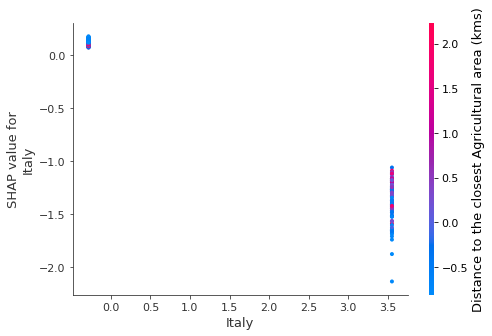

In [166]:
#very useful when conditioned upon countries
shap.dependence_plot("Italy", shap_values, features_train)

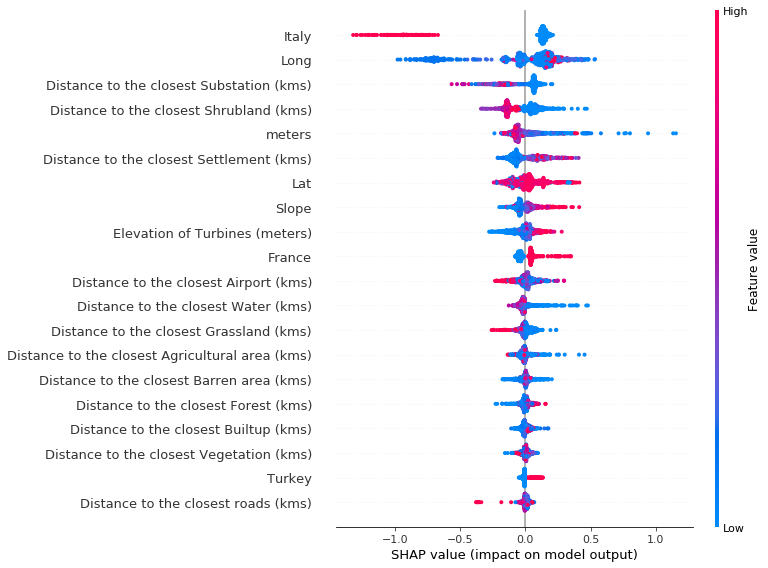

In [136]:
shap.summary_plot(shap_values, features_train)

## GP

In [147]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('100',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


In [148]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel,Matern,RationalQuadratic,ExpSineSquared,DotProduct

kernel1=3.0 *RBF(3, (1e-23, 1e10) ) + WhiteKernel(1, (1e-23, 1e5))
kernel2=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)+ WhiteKernel(1, (1e-23, 1e5))
kernel3=1.0 * Matern(length_scale=1, length_scale_bounds=(1e-1, 10.0),nu=1.5)+RBF(3, (1e-23, 1e10) )+ WhiteKernel(1, (1e-23, 1e5))
kernel4=1.0*Matern(length_scale=1, length_scale_bounds=(1e-1, 10.0),nu=0.5)+3* (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)+WhiteKernel(1, (1e-23, 1e5))
kernel5=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)+Matern(length_scale=1, length_scale_bounds=(1e-1, 10.0),nu=1.5)+ WhiteKernel(1, (1e-23, 1e5))
kernel_candidate_list=[kernel1,kernel2,kernel3,kernel4,kernel5]
#kernel=None
#kernel = ConstantKernel(5, (1e-3, 1e3))*RBF(3, (1e-23, 1e10) ) + WhiteKernel(1, (1e-23, 1e5))

#         WhiteKernel(2, (1e-23, 1e5))
#np.ones(subset_data_x.shape[1])
#kernel=3.0 * Matern(length_scale=1, length_scale_bounds=(1e-1, 10.0),nu=2.5) + WhiteKernel(1, (1e-23, 1e5))
#kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)+ WhiteKernel(1, (1e-23, 1e5))
#kernel=1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,length_scale_bounds=(0.1, 10.0),periodicity_bounds=(1.0, 10.0))+ WhiteKernel(1, (1e-23, 1e5))
#kernel= 3* (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)+ WhiteKernel(1, (1e-23, 1e5))

#now try combinations of successful kernels so far
#kernel=1.0 * Matern(length_scale=1, length_scale_bounds=(1e-1, 10.0),nu=1.5)+RBF(3, (1e-23, 1e10) )+ WhiteKernel(1, (1e-23, 1e5))
#kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)+RBF(3, (1e-23, 1e10) )+ WhiteKernel(1, (1e-23, 1e5))
#kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)+Matern(length_scale=np.ones(features_train.shape[1]), length_scale_bounds=(1e-1, 10.0),nu=1.5)+ WhiteKernel(1, (1e-23, 1e5))
#kernel=1.0*RBF(3, (1e-23, 1e10) )+3* (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)+WhiteKernel(1, (1e-23, 1e5))
#kernel=1.0*Matern(length_scale=1, length_scale_bounds=(1e-1, 10.0),nu=0.5)+3* (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)+WhiteKernel(1, (1e-23, 1e5))
#kernel=1.0*RationalQuadratic(length_scale=1.0, alpha=0.1)+3* (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)+WhiteKernel(1, (1e-23, 1e5))
#default kernel
#default kernel


In [149]:
model_train=[]
model_kernel_final=[]
model_kernel_loglikelihood=[]
kfold=5
cv = KFold(n_splits=kfold, shuffle=True, random_state=1)

In [57]:
for kernel in kernel_candidate_list:
    gpr = GaussianProcessRegressor(random_state=0,n_restarts_optimizer=2,kernel=kernel,normalize_y=True)
    nested_score = cross_val_score(gpr, features_train, windspeed_train, scoring='neg_mean_squared_error',cv=cv)
    #estimated training error
    print("Model is estimated to have generalisation error of {} with standard deviation {}.".format(nested_score.mean(),nested_score.std()))
    model_train.append((nested_score.mean(),nested_score.std()))
    gpr.fit(features_train, windspeed_train)
    model_kernel_final.append(gpr.kernel_)
    model_kernel_loglikelihood.append(gpr.log_marginal_likelihood())

            

Model is estimated to have generalisation error of -0.5222423203776989 with standard deviation 0.06940409721932503.
Model is estimated to have generalisation error of -0.4175401643384348 with standard deviation 0.04071483862986308.
Model is estimated to have generalisation error of -0.4221158046422282 with standard deviation 0.044052718170829785.
Model is estimated to have generalisation error of -0.4094392699730555 with standard deviation 0.040122191963237734.
Model is estimated to have generalisation error of -0.43163183694898716 with standard deviation 0.05118448774226371.


In [58]:
model_kernel_loglikelihood

[-1256.4299968395148,
 -1149.7774714468246,
 -1150.4323889677735,
 -1219.7376549876778,
 -1163.0385895104707]

In [59]:
Final_choice=model_kernel_loglikelihood.index(max(model_kernel_loglikelihood))
print('Final kernel choice is kernel{}'.format(Final_choice+1))

Final kernel choice is kernel2


In [63]:
model_train[1]

(-0.4175401643384348, 0.04071483862986308)

In [150]:
gpr = GaussianProcessRegressor(random_state=0,n_restarts_optimizer=2,kernel=kernel3,normalize_y=True)

In [151]:
gpr.fit(features_train, windspeed_train)
y_predict=gpr.predict(features_test)
print(np.vstack((y_predict, windspeed_test)).T)
final_error=-np.sum(np.square(y_predict-windspeed_test))/len(windspeed_test)
print('mse error on test set is {}.'.format(final_error))

perm = PermutationImportance(gpr, random_state=1).fit(features_test, windspeed_test)
explaination=eli5.explain_weights_df(perm, feature_names = features_test.columns.tolist(),top=10)
print(explaination)

[[7.44151181 7.35397308]
 [7.15684251 7.68906609]
 [7.49936603 7.87549   ]
 [7.63332968 7.31934333]
 [7.64494378 7.83730438]
 [7.40094313 7.26626355]
 [7.62911807 8.2471    ]
 [6.99225859 6.938845  ]
 [6.68449427 6.69718818]
 [6.8567485  6.80512625]
 [7.03585247 7.11139   ]
 [7.49637608 7.5129144 ]
 [6.4616375  6.14659   ]
 [6.86990706 6.50493   ]
 [6.85638746 7.11918   ]
 [6.56009934 6.39306833]
 [6.95738238 7.169665  ]
 [6.85105102 6.98422333]
 [6.66977819 6.979965  ]
 [6.61401069 6.55824   ]
 [7.00947448 6.951284  ]
 [6.5720691  6.75161667]
 [6.84970185 6.6927225 ]
 [6.92559311 6.770054  ]
 [7.16690963 7.30231333]
 [7.16494911 6.96236444]
 [6.99225859 6.938845  ]
 [7.30708679 7.725636  ]
 [6.89821136 6.74963714]
 [7.10063682 6.6389675 ]
 [7.08686657 6.991476  ]
 [6.9306557  6.86955643]
 [6.99225859 6.938845  ]
 [7.11875495 7.0087425 ]
 [6.57336476 7.53789125]
 [6.69263816 6.45153333]
 [7.05627433 7.06046   ]
 [6.64178323 6.55812   ]
 [6.90139286 6.67409167]
 [7.37939061 7.34049833]


In [152]:
gpr.kernel_

0.784**2 * Matern(length_scale=0.507, nu=1.5) + RBF(length_scale=3.66) + WhiteKernel(noise_level=0.00993)

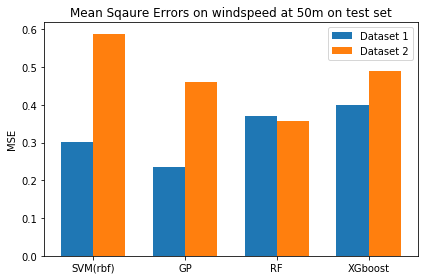

In [138]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

dataset1_mse=[0.302,0.234,0.371,0.40]
dataset2_mse=[0.589,0.460,0.358,0.49]
ind = np.arange(len(dataset1_mse))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, dataset1_mse, width,
                label='Dataset 1')
rects2 = ax.bar(ind + width/2, dataset2_mse, width,
                label='Dataset 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Mean Sqaure Errors on windspeed at 50m on test set')
ax.set_xticks(ind)
ax.set_xticklabels(('SVM(rbf)', 'GP', 'RF', 'XGboost'))
ax.legend()


fig.tight_layout()

plt.show()

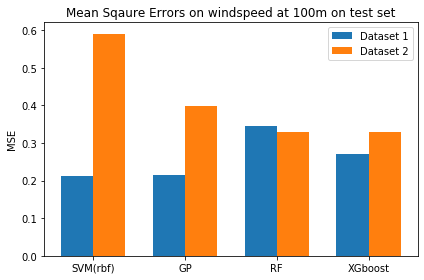

In [139]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

dataset1_mse=[0.212,0.214,0.345,0.27]
dataset2_mse=[0.591,0.398,0.329,0.33]
ind = np.arange(len(dataset1_mse))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, dataset1_mse, width,
                label='Dataset 1')
rects2 = ax.bar(ind + width/2, dataset2_mse, width,
                label='Dataset 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Mean Sqaure Errors on windspeed at 100m on test set')
ax.set_xticks(ind)
ax.set_xticklabels(('SVM(rbf)', 'GP', 'RF', 'XGboost'))
ax.legend()


fig.tight_layout()

plt.show()

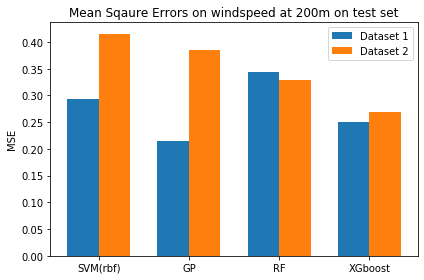

In [140]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

dataset1_mse=[0.293,0.215,0.344,0.25]
dataset2_mse=[0.416,0.385,0.329,0.27]
ind = np.arange(len(dataset1_mse))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, dataset1_mse, width,
                label='Dataset 1')
rects2 = ax.bar(ind + width/2, dataset2_mse, width,
                label='Dataset 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Mean Sqaure Errors on windspeed at 200m on test set')
ax.set_xticks(ind)
ax.set_xticklabels(('SVM(rbf)', 'GP', 'RF', 'XGboost'))
ax.legend()


fig.tight_layout()

plt.show()